In [1]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [2]:
sales_s = pd.read_pickle("sales_s.pkl")
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


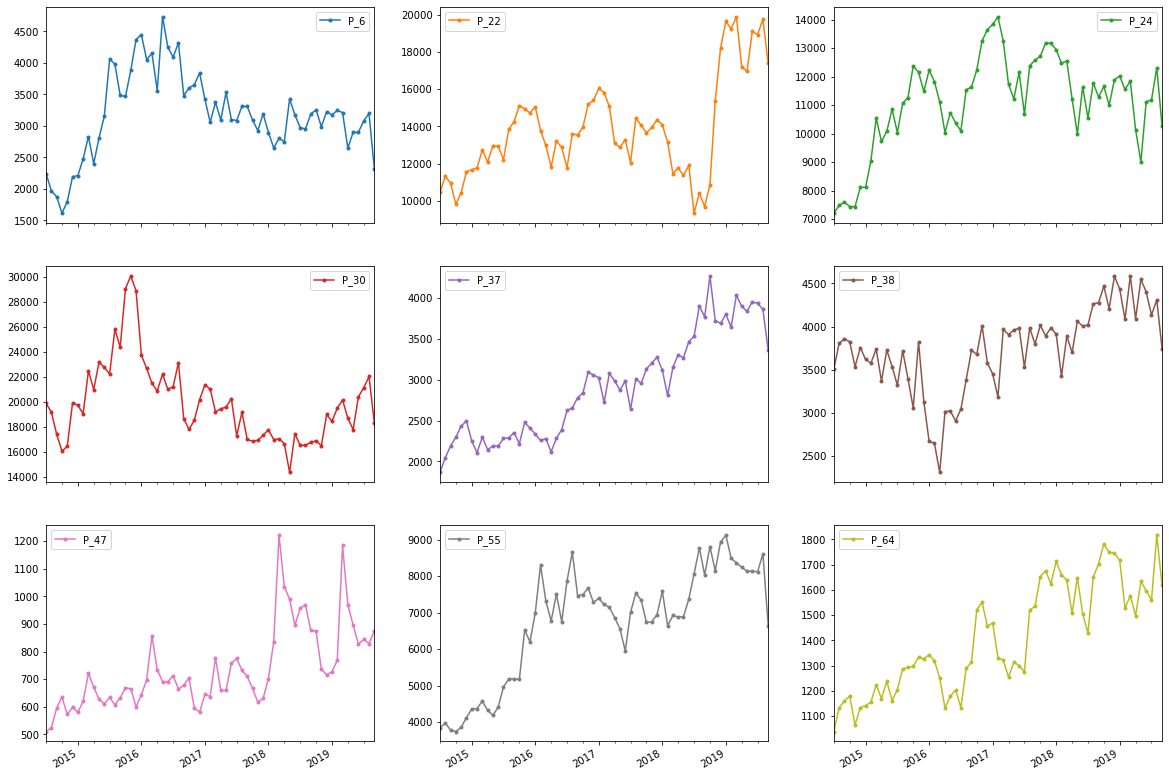

In [3]:
sales_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

## Analyse d'autocorrélation

\
L'analyse d'autocorrélation illustre le potentiel de prédiction des données de séries chronologiques. Les graphiques d'autocorrélation résument graphiquement la force d'une relation avec une observation dans une série chronologique avec des observations à des pas de temps antérieurs. Le coefficient de Pearson est utilisé pour mesurer l'autocorrélation. Ainsi, l'analyse suivante n'est pertinente que pour les données avec une distribution gaussienne normale.

Un tracé de l'autocorrélation d'une série chronologique par décalage est appelé la fonction d'autocorrélation (ACF). Ce graphique est parfois appelé corrélogramme ou graphique d'autocorrélation. Le graphique montre la valeur de décalage le long de l'axe des x et la corrélation sur l'axe des y entre -1 et 1. Les intervalles de confiance sont dessinés sous forme de cône. Par défaut, il est défini sur un intervalle de confiance de 95%, ce qui suggère que les valeurs de corrélation en dehors de ce code sont très probablement une corrélation.

En général, la corrélation «partielle» entre deux variables est la quantité de corrélation entre elles qui n'est pas expliquée par leurs corrélations mutuelles avec un ensemble spécifié d'autres variables. Par exemple, si nous régressons une variable Y sur d'autres variables X1, X2 et X3, la corrélation partielle entre Y et X3 est la quantité de corrélation entre Y et X3 qui n'est pas expliquée par leurs corrélations communes avec X1 et X2.

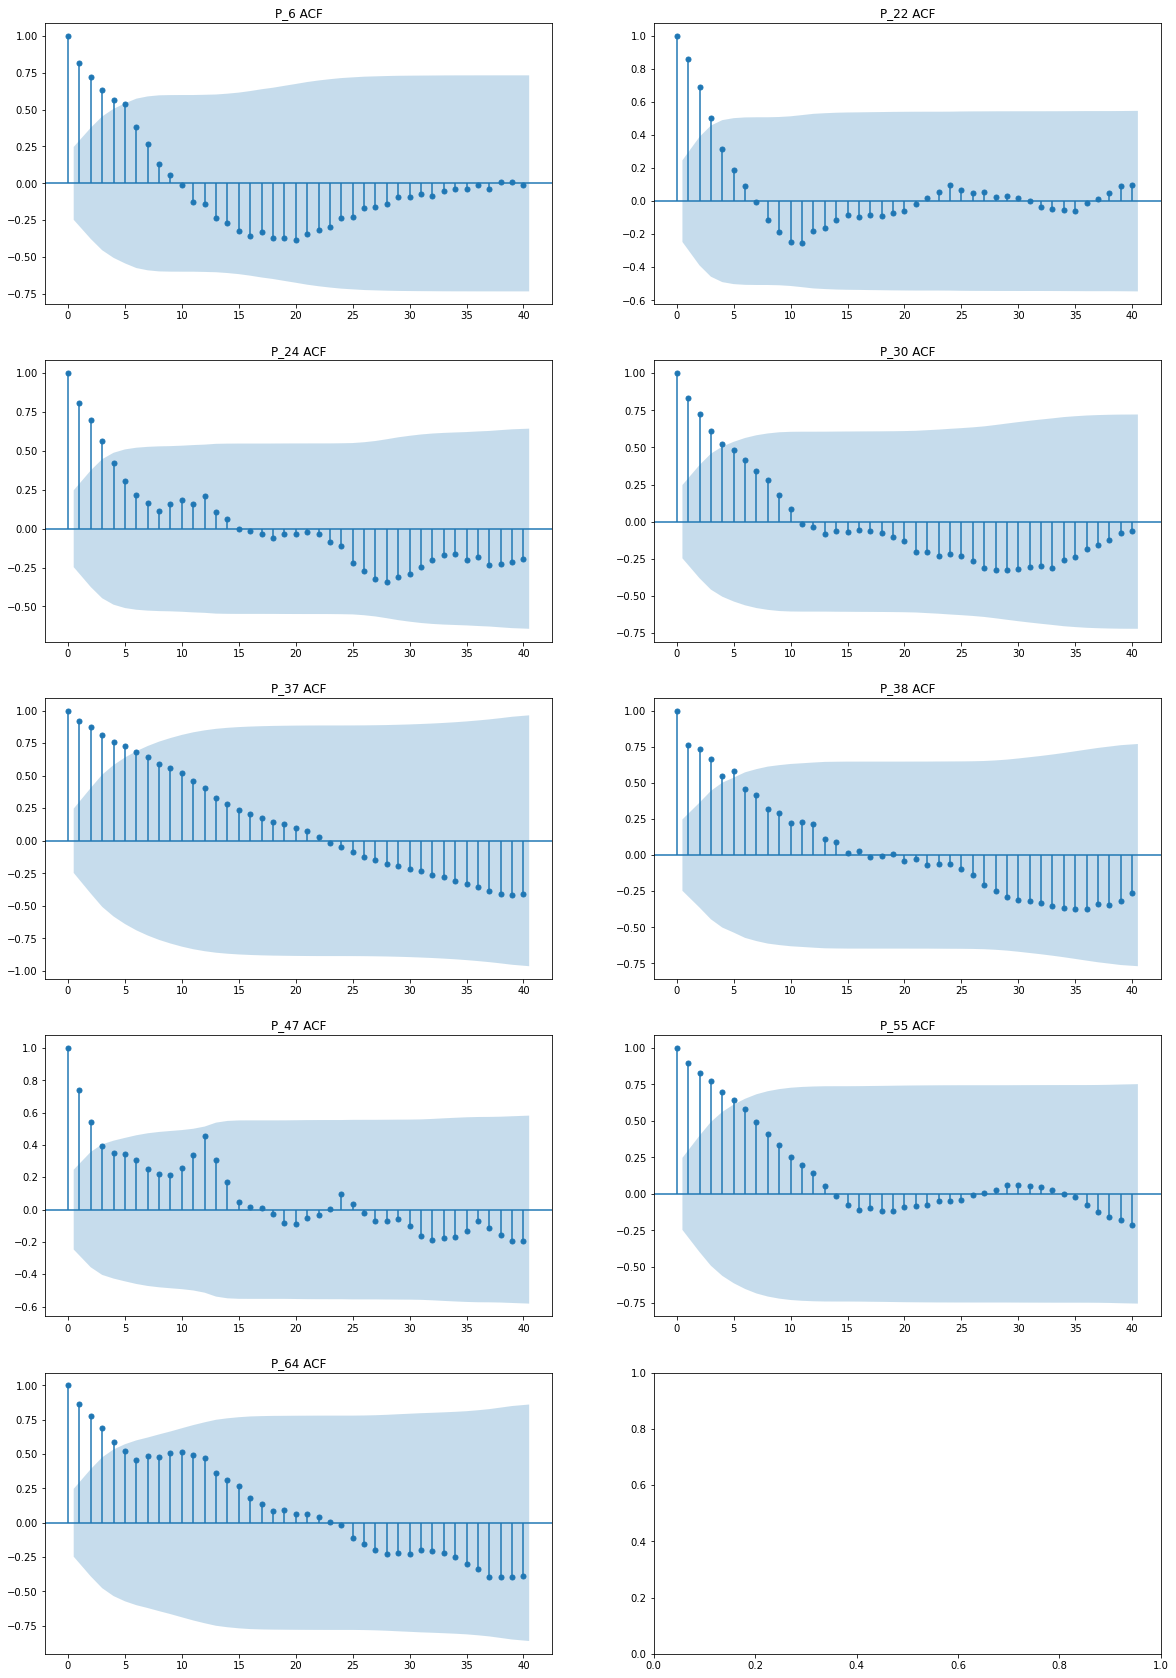

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30), sharex=False)
axs = axes.flatten()
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(sales_s[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

D'après les correlogrames des séries temporelles ci dessus, on peut constater que la fonction d'autocorrelation se dégrade ou diminue lentement, ce qui indique la non stationnarité des séries.
De plus, dans les deux séries des produits p_47 et p_64 l'ACF montre une oscillation et des pics qui se reproduisent avec des décalages de 12 mois indicant un effet de saisonnalité.


Afin d'estimer le terme de différenciation saisonnière D, on a effectué deux tests de saisonnalité pour différents niveaux de D pour estimer le nombre de différences saisonnières nécessaires pour rendre la série chronologique stationnaire et on a sélectionné la valeur maximale de D pour laquelle la série chronologique est jugée saisonnièrement stationnaire par le test statistique.

De même, pour estimer le terme de différenciation d, on a effectué trois test statistiques de racine unitaire : Augmented Dickey Fuller (ADF), Phillips–Perron (PP) et Kwiatkowski–Phillips–Schmidt–Shin (KPSS) pour différents niveaux de d afin d'estimer le nombre de différences nécessaires pour rendre chaque série chronologique stationnaire, et on a sélectionné la valeur maximale de d pour laquelle la série temporelle est jugée stationnaire par le test statistique.

Le tableau ci dessous synthétise les résultats, chaque test de saisonnalité indique la présence ou absence d'un effet de saisonnalié, et de même pour les tests de racine unitaire, ainsi que les ordres de differenciation nécaissaires pour stationnarier la série.

In [5]:
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), max(n_adf, n_kpss, n_pp))

In [6]:
res = pd.DataFrame(sales_s.columns, columns=["Series"])
res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(sales_s[i])[j]\
                                           for i in sales_s.columns] for j in range(7)]
res=res.set_index("Series")
res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
res

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Oui,Non,Oui,1
P_22,Non,Non,0,Oui,Oui,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_30,Non,Non,0,Oui,Oui,Oui,1
P_37,Non,Non,0,Oui,Oui,Non,1
P_38,Non,Non,0,Oui,Oui,Non,1
P_47,Non,Oui,1,Non,Oui,Non,1
P_55,Non,Non,0,Oui,Oui,Oui,1
P_64,Non,Oui,1,Non,Oui,Non,1


On a procedé par la suite à la stationnarisation des séries en appliquant la differenciation adéquate, et on a reéffectué les mêmes tests pour confirmer qu'on a atteint la stationnarité des séries.

In [7]:
stationnaries = sales_s.copy()
stationnaries = stationnaries.diff(1).iloc[1:]
stationnaries.loc[:,["P_47", "P_64"]] = stationnaries.loc[:,["P_47", "P_64"]].diff(12)
stationnaries.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-08-31,-274.0,852.0,273.0,-688.0,178.0,294.0,NaN,131.0,NaN
2014-09-30,-93.0,-363.0,115.0,-1782.0,145.0,55.0,NaN,-193.0,NaN
2014-10-31,-262.0,-1134.0,-157.0,-1348.0,109.0,-36.0,NaN,-42.0,NaN
2014-11-30,181.0,605.0,-1.0,396.0,135.0,-288.0,NaN,116.0,NaN
2014-12-31,399.0,1141.0,675.0,3452.0,66.0,222.0,NaN,264.0,NaN


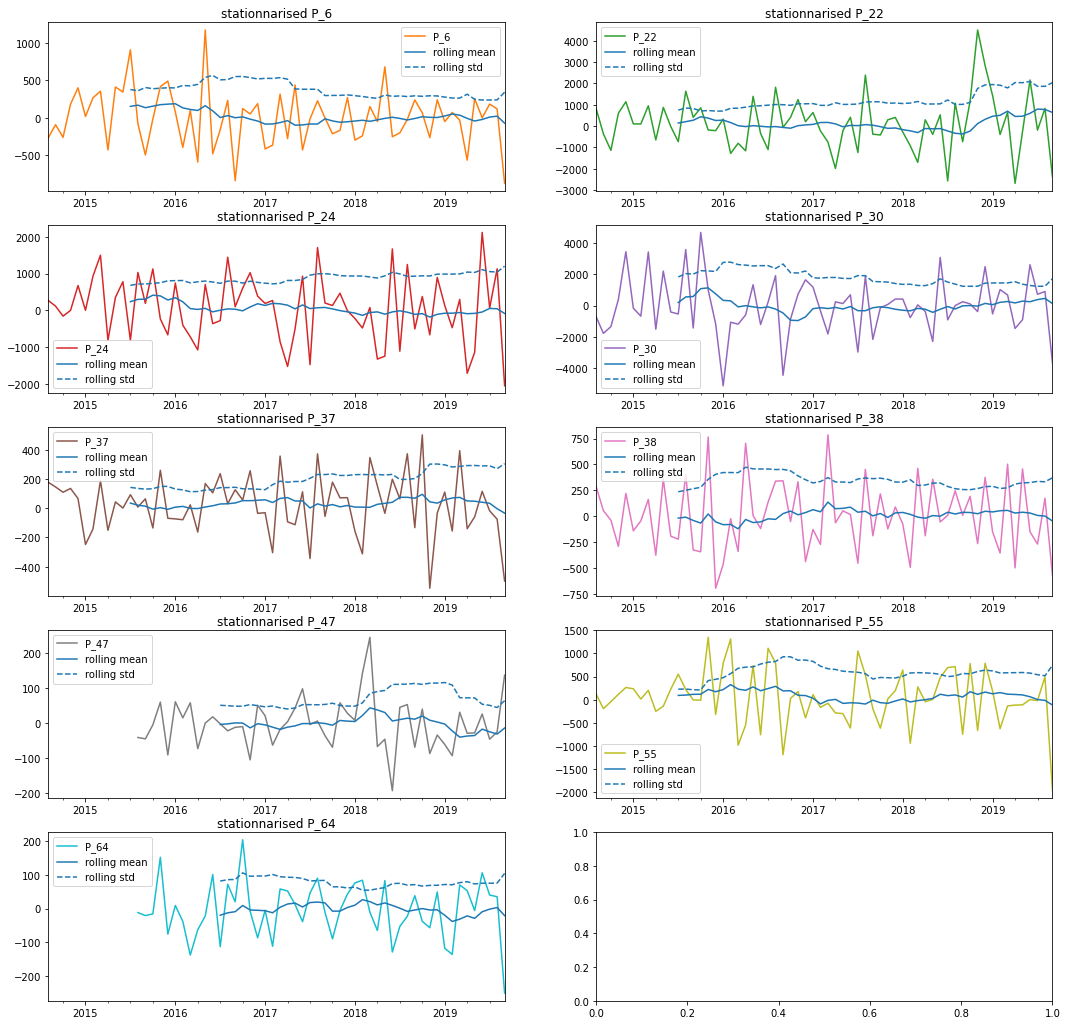

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(18, 18))
axs = axs.flatten()
cols = [next(color_cycle)]*3
for i, item in enumerate(sales_s.columns):
    stationnaries[item].plot(title=f"stationnarised {item}",
                     color=next(color_cycle),
                     ax=axs[i])
    stationnaries[item].rolling(12).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="rolling mean")
    stationnaries[item].rolling(12).std().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="rolling std")
    axs[i].legend()

In [9]:
res = pd.DataFrame(stationnaries.columns, columns=["Series"])
res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(stationnaries[i])[j]\
                                           for i in stationnaries.columns] for j in range(7)]
res=res.set_index("Series")
res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
res

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Non,Non,Non,0
P_22,Non,Non,0,Non,Non,Non,0
P_24,Non,Non,0,Non,Non,Non,0
P_30,Non,Non,0,Non,Non,Non,0
P_37,Non,Non,0,Non,Non,Non,0
P_38,Non,Non,0,Non,Non,Non,0
P_47,Non,Non,0,Non,Non,Non,0
P_55,Non,Non,0,Non,Non,Non,0
P_64,Non,Non,0,Non,Non,Non,0


On peut constater la stationnarité des séries a partir des corrélogrammes ci dessous, ces derniers nous permettent aussi de déterminer l'ordre d'ARIMA, mais la détéction visuelle ne permet pas toujours d'atteindre la performance maximale, c'est pourquoi on a utilisé la fonction auto_arima qui permet d'ajuste le meilleur modèle ARIMA à une série temporelle univariée selon un critère d'information fourni (soit AIC, AICc, BIC ou HQIC). La fonction effectue une recherche (soit pas à pas, soit parallélisée) sur des ordres de modèle et saisonniers possibles dans les contraintes fournies, et sélectionne les paramètres qui minimisent la métrique donnée.

L'approche parallèle est une méthode de brute force naïve, il s'agit d'une recherche de grille (grid search) sur diverses combinaisons d'hyperparamètres. Cela prendra généralement plus de temps pour plusieurs raisons. Tout d'abord, il n'y a pas de procédure intelligente sur la façon dont les commandes de modèles sont testées ; ils sont tous testés (pas de court-circuit), ce qui peut prendre un certain temps.

L'approche par étapes (stepwise) suit la stratégie définie par Hyndman et Khandakar dans leur article de 2008, « Automatic Time Series Forecasting : The Forecast Package for R ».

Étape 1 : Essayez quatre modèles possibles pour commencer :

ARIMA(2,d,2) si m = 1 et ARIMA(2,d,2)(1,D,1) si m > 1\
ARIMA(0,d,0) si m = 1 et ARIMA(0,d,0)(0,D,0) si m > 1\
ARIMA(1,d,0) si m = 1 et ARIMA(1,d,0)(1,D,0) si m > 1\
ARIMA(0,d,1) si m = 1 et ARIMA(0,d,1)(0,D,1) si m > 1\
Le modèle avec le plus petit AIC (ou BIC, ou AICc, etc., selon les critères de minimisation) est sélectionné. C'est le "meilleur" modèle actuel.

Étape 2 : Considérez un certain nombre d'autres modèles :

Où l'un des p, q, P et Q peut varier de ±1 par rapport au meilleur modèle actuel\
Où p et q varient tous les deux de ±1 par rapport au meilleur modèle actuel\
Où P et Q varient tous les deux de ±1 par rapport au meilleur modèle actuel\
Chaque fois qu'un modèle avec un critère d'information inférieur est trouvé, il devient le nouveau meilleur modèle actuel, et la procédure est répétée jusqu'à ce qu'il ne puisse pas trouver un modèle proche du meilleur modèle actuel avec un critère d'information inférieur ou que le processus dépasse l'un des seuils d'exécution défini via arima.StepwiseContext.


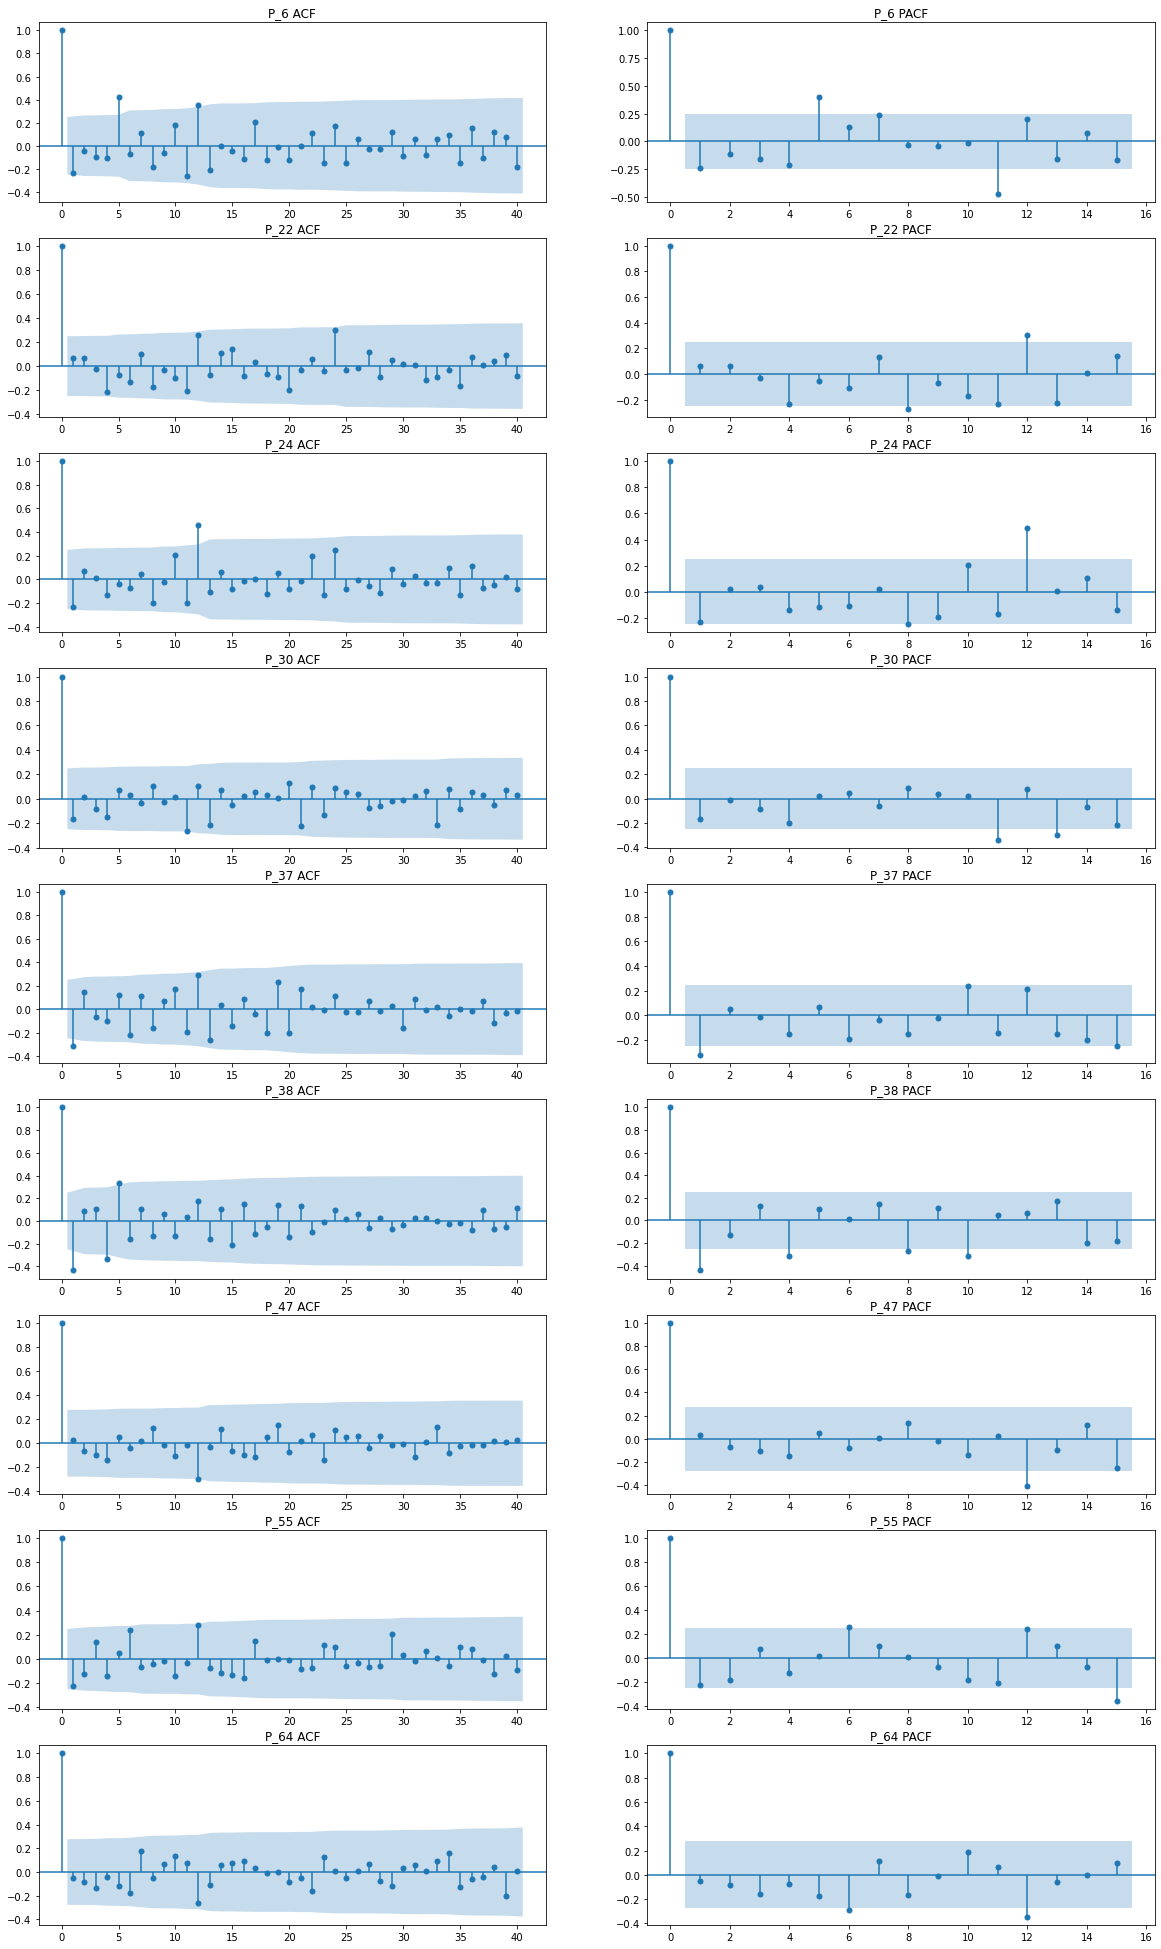

In [10]:
fig, axes = plt.subplots(9, 2, figsize=(20, 35), sharex=False)
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(stationnaries[col].dropna().values.squeeze(), lags=40, \
                             ax=axes[i,0], title=f"{col} ACF", alpha=alpha)
    sm.graphics.tsa.plot_pacf(stationnaries[col].dropna().values.squeeze(), lags=15, \
                              ax=axes[i,1], title=f"{col} PACF", alpha=alpha)

In [11]:
models = [0]*len(sales_s.columns)
for i, col in enumerate(sales_s.columns):
    models[i] = pm.auto_arima(sales_s[col], start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
    #                       d=None,           # let model determine 'd'
    #                       seasonal=True,   # No Seasonality
    #                       start_P=0, 
    #                       D=0, 
#                           trace=True,
    #                       error_action='ignore',  
    #                       suppress_warnings=True, 
                          stepwise=True)

In [12]:
res = pd.DataFrame(columns=['Best model', 'AIC','BIC'])
for i in range(len(sales_s.columns)):
    tbl = models[i].summary().tables[0].data
    res = res.append({"Best model": tbl[1][1], \
                      "AIC": float(tbl[2][3]),\
                      "BIC": float(tbl[3][3])}\
                     ,ignore_index=True)
res.set_index(sales_s.columns)

,Best model,AIC,BIC
P_6,"SARIMAX(0, 1, 0)x(1, 0, 0, 12)",902.923,907.177
P_22,"SARIMAX(0, 1, 0)",1063.119,1065.246
P_24,"SARIMAX(0, 1, 1)x(1, 0, [], 12)",1010.217,1016.599
P_30,"SARIMAX(0, 1, 0)",1109.946,1112.074
P_37,"SARIMAX(1, 1, 0)x(1, 0, 0, 12)",829.734,836.116
P_38,"SARIMAX(2, 1, 1)x(2, 0, [], 12)",881.211,893.974
P_47,"SARIMAX(0, 1, 0)x(1, 1, 0, 12)",566.959,570.783
P_55,"SARIMAX(0, 1, 1)x(1, 0, [], 12)",964.691,971.072
P_64,"SARIMAX(0, 1, 0)x(0, 1, [1], 12)",581.183,585.007


On a effectué la prévision de l'ensemble des séries par les meilleurs modèles ARIMA séléctionnés selon deux approches.

La méthode de prévision statique calcule une séquence de prévisions à un pas d'avance, en utilisant les valeurs réelles plutôt que prévues pour les variables dépendantes décalées, si elles sont disponibles. En effet, pour effectuer la prévision d'un nouveau mois, le modèle est mis a jour en incluant la valeur réelle du mois précédant, cette méthode est plus performante et donne des prévisions moins biaisées mais ne peut etre utilisée que pour prévoir un seul mois à l'avance. 

La méthode de prévision dynamique calcule des prévisions dynamiques en plusieurs étapes à partir de la première période de l'échantillon de prévision, les valeurs précedemment prévues pour les variables dépendantes décalées sont utilisées pour former la prévision de la valeur actuelle. Cette méthode est utile lorsque l'entreprise s'interesse à effectuer une prévision à long terme, c'est dire prévoir les ventes de plusieurs mois à l'avance.

Les graphiques ci-dessous représentent les prévisions effectuées par les deux méthodes ainsi que les intervalles de confiance (95%).
On peut constater que les séries des deux produits P_22 et P_30 correspondent à des marches aléatoires, la meilleure prévision dans ce cas est la valeur précendente.
Les intervalles de prévision associés à la méthode dynamique s'allongent à mesure que l'horizon de prévision s'allonge, plus nous prévoyons à l'avance, plus l'incertitude est associée à la prévision, et donc plus les intervalles de prévision sont larges.
Dans les prévisions par la méthode statique, la variation de la distribution des prévisions est presque la même que la variation des résidus.

Must read : \
https://www.kddanalytics.com/practical-time-series-forecasting-deterministic-stochastic-trend-2/ \
https://otexts.com/fpp2/stochastic-and-deterministic-trends.html \
http://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [13]:
train_arima = sales_s.loc[:'2018-12-31']
test_arima = sales_s.loc['2019-01-31':]

In [14]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    acf1 = acf(forecast-actual)[1]              # ACF1
    return({'mape':mape, 'mae': mae, 'rmse':rmse, 'acf1':acf1, 'corr':corr})

C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657:

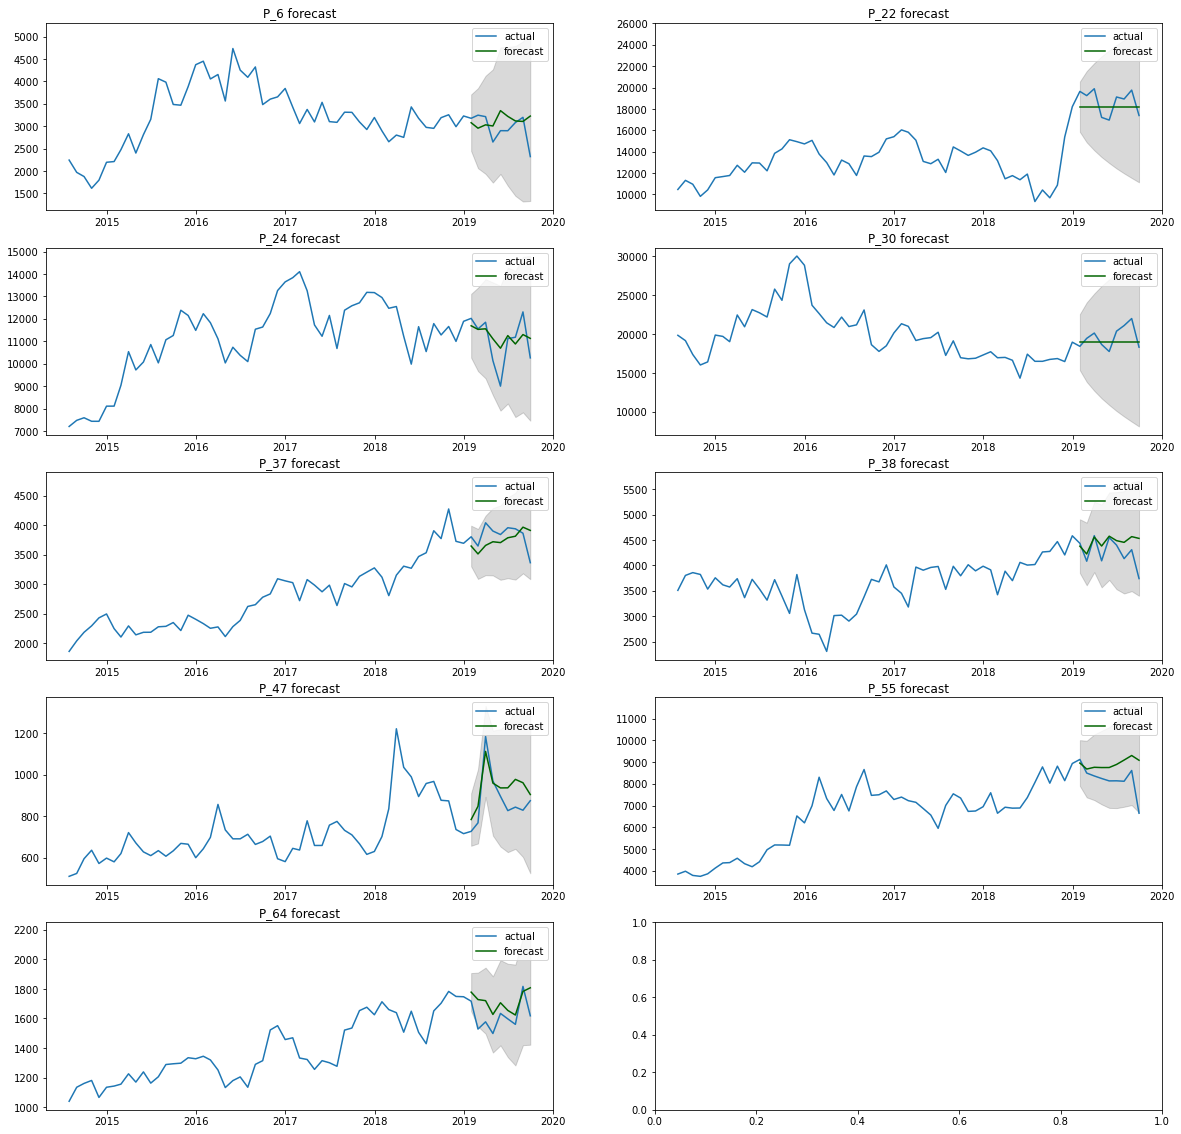

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
fitted_dynamic = [0]*len(sales_s.columns)
accuracies_dynamic = [0]*len(sales_s.columns)
for i, item in enumerate(sales_s.columns):
    fitted_dynamic[i] = models[i].fit(train_arima.iloc[:,i])
    fc, confint = fitted_dynamic[i].predict(n_periods=9, return_conf_int=True)
    index_of_fc = sales_s.loc['2019-01-31':].index

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    axs[i].plot(sales_s.iloc[:,i], label="actual")
    axs[i].plot(fc_series, color='darkgreen', label="forecast")
    axs[i].fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    axs[i].set_title(f"{item} forecast")
    axs[i].legend()
    
    accuracies_dynamic[i] = forecast_accuracy(fc_series, test_arima.iloc[:,i])

C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\abdel.DESKTOP-CJ9MCIF\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the def

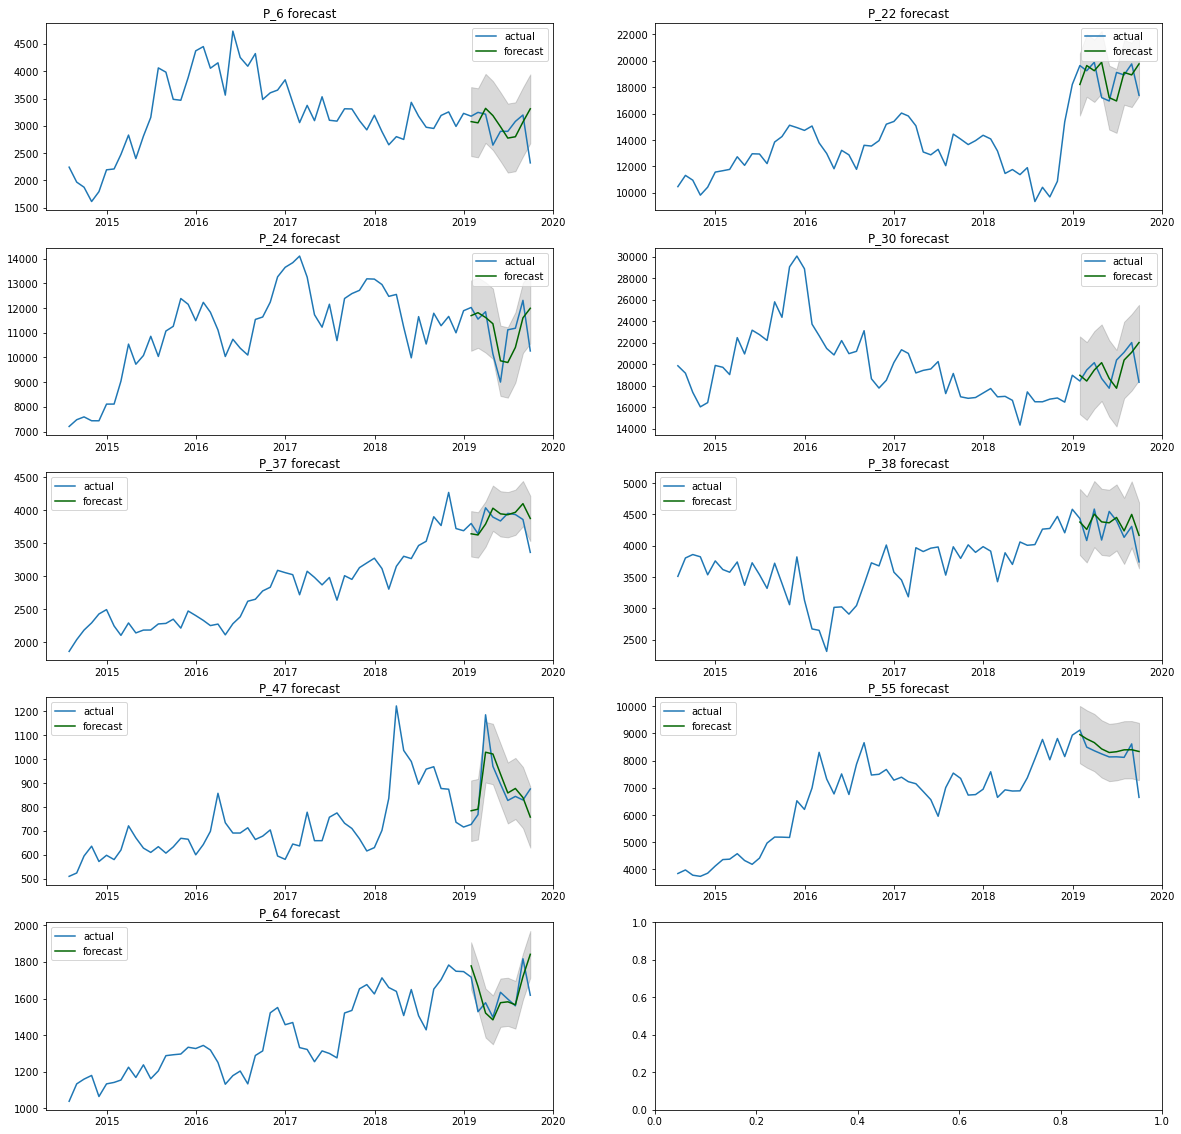

In [16]:
index_of_fc = sales_s.loc['2019-01-31':].index
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
fitted_static = [0]*len(sales_s.columns)
accuracies_static = [0]*len(sales_s.columns)
for i, item in enumerate(sales_s.columns):
    fitted_static[i] = models[i].fit(train_arima.iloc[:,i])
    preds =np.zeros((len(test_arima)))
    conf_int = np.zeros((len(test_arima),2))

    for j in range(len(test_arima)):
        new_preds, new_conf_int = fitted_static[i].predict(n_periods=1, return_conf_int=True)
        fitted_static[i].update([test_arima.iloc[j,i]])
        preds[j] = new_preds
        conf_int[j] = new_conf_int


    # make series for plotting purpose
    fc_series = pd.Series(preds, index=index_of_fc)
    lower_series = pd.Series(conf_int[:, 0], index=index_of_fc)
    upper_series = pd.Series(conf_int[:, 1], index=index_of_fc)
    
    axs[i].plot(sales_s.iloc[:,i], label="actual")
    axs[i].plot(fc_series, color='darkgreen', label="forecast")
    axs[i].fill_between(test_arima.iloc[:,i].index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    axs[i].set_title(f"{item} forecast")
    axs[i].legend()
    
    accuracies_static[i] = forecast_accuracy(fc_series, test_arima.iloc[:,i])

In [17]:
res = pd.DataFrame(columns=['mape', 'mae', 'rmse','acf1','corr'])
for i in range(len(sales_s.columns)):
    res = res.append(accuracies_dynamic[i], ignore_index=True)
res.set_index(sales_s.columns)

,mape,mae,rmse,acf1,corr
P_6,0.111873,303.176930,392.228170,0.109293,-0.433333
P_22,0.061665,1156.888889,1200.325604,0.019330,NaN
P_24,0.060366,624.455874,808.256265,0.130839,0.788921
P_30,0.059993,1214.777778,1478.102876,0.098966,NaN
P_37,0.057591,215.024574,256.849828,0.321045,-0.145695
P_38,0.055420,222.121861,318.007923,0.073396,0.311923
P_47,0.087168,73.988869,85.017838,0.370916,0.886589
P_55,0.098111,746.358977,987.120088,0.158359,-0.152731
P_64,0.066672,105.542075,120.421351,-0.080069,0.658706


In [18]:
res = pd.DataFrame(columns=['mape', 'mae', 'rmse','acf1','corr'])
for i in range(len(sales_s.columns)):
    res = res.append(accuracies_static[i], ignore_index=True)
res.set_index(sales_s.columns)

,mape,mae,rmse,acf1,corr
P_6,0.106227,282.464905,400.936692,0.018036,-0.289119
P_22,0.066428,1217.111111,1523.954724,-0.236970,-0.023999
P_24,0.077816,827.064467,961.276146,-0.013498,0.461163
P_30,0.072208,1393.555556,1717.856675,-0.091637,0.148997
P_37,0.044254,163.513240,220.687483,0.245024,0.267573
P_38,0.042141,173.036547,207.800716,-0.238915,0.786628
P_47,0.062523,57.878159,73.435933,-0.134778,0.818072
P_55,0.051962,386.609794,602.725191,-0.271747,0.617164
P_64,0.045675,74.294558,99.515216,-0.207080,0.577652


Ljung-Box (Q) : \
    H0: The residuals are independently distributed.\
    H1: The residuals are not independently distributed; they exhibit serial correlation.\
    Prob(Q)<0.05   =>   the residuals are not independent


Heteroskedasticity (H):\
    H0: The null hypothesis is of no heteroskedasticity.\
    H1: heteroskedasticity.\
    Prob(H)<0.05   =>   heteroskedasticity.


Jarque-Bera (JB):\
    H0: Normality\
    H1: No normality\
    Prob(H)<0.05   =>   no normality

Pour la validation des modèles obtenus, on a effectué un diagnostic des résidus.
le tableau ci-dessous synthétise les résultats des tests de bruit blanc, homoscedasticité et normalité pour le résidus de chacune des séries

In [19]:
def Verif(x):
    return "Vérifié" if x else "Non Vérifié" 

In [20]:
res = pd.DataFrame(columns=['Prob(Q)', 'White noise', 'Prob(H)','Homoscedasticity','Prob(JB)','Normality'])
for i in range(len(sales_s.columns)):
    tbl = models[i].summary().tables[2].data
    res = res.append({"Prob(Q)": float(tbl[1][1]), "White noise": Verif(float(tbl[1][1])>0.05), \
                      "Prob(H)": float(tbl[3][1]), "Homoscedasticity": Verif(float(tbl[3][1])>0.05), \
                      "Prob(JB)": float(tbl[1][3]), "Normality": Verif(float(tbl[1][3])>0.05)}\
                     ,ignore_index=True)
res.set_index(sales_s.columns)

,Prob(Q),White noise,Prob(H),Homoscedasticity,Prob(JB),Normality
P_6,0.43,Vérifié,0.73,Vérifié,0.29,Vérifié
P_22,0.60,Vérifié,0.00,Non Vérifié,0.01,Non Vérifié
P_24,0.60,Vérifié,0.65,Vérifié,0.34,Vérifié
P_30,0.18,Vérifié,0.09,Vérifié,0.50,Vérifié
P_37,1.00,Vérifié,0.00,Non Vérifié,0.06,Vérifié
P_38,0.74,Vérifié,0.02,Non Vérifié,0.49,Vérifié
P_47,0.89,Vérifié,0.10,Vérifié,0.00,Non Vérifié
P_55,0.68,Vérifié,0.71,Vérifié,0.40,Vérifié
P_64,0.27,Vérifié,0.69,Vérifié,0.28,Vérifié


In [21]:
res.style.set_properties(
    **{'color': 'black !important',
       'border': '1px black solid !important'}
).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px black solid !important')]
}])

,Prob(Q),White noise,Prob(H),Homoscedasticity,Prob(JB),Normality
0,0.430000,Vérifié,0.730000,Vérifié,0.290000,Vérifié
1,0.600000,Vérifié,0.000000,Non Vérifié,0.010000,Non Vérifié
2,0.600000,Vérifié,0.650000,Vérifié,0.340000,Vérifié
3,0.180000,Vérifié,0.090000,Vérifié,0.500000,Vérifié
4,1.000000,Vérifié,0.000000,Non Vérifié,0.060000,Vérifié
5,0.740000,Vérifié,0.020000,Non Vérifié,0.490000,Vérifié
6,0.890000,Vérifié,0.100000,Vérifié,0.000000,Non Vérifié
7,0.680000,Vérifié,0.710000,Vérifié,0.400000,Vérifié
8,0.270000,Vérifié,0.690000,Vérifié,0.280000,Vérifié


In [54]:
# import pmdarima
# import arch

# # fit ARIMA on returns 
# arima_model = models[5]
# arima_residuals = arima_model.arima_res_.resid

# # fit a GARCH(1,1) model on the residuals of the ARIMA model
# garch = arch.arch_model(arima_residuals, p=1, q=1)
# garch_model = garch.fit()

# # Use ARIMA to predict mu
# predicted_mu = arima_model.predict(n_periods=9)
# print("here : ", predicted_mu)
# # Use GARCH to predict the residual
# garch_forecast = garch_model.forecast(horizon=9)
# predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# print("here : ", predicted_et)
# # Combine both models' output: yt = mu + et
# prediction = predicted_mu + predicted_et

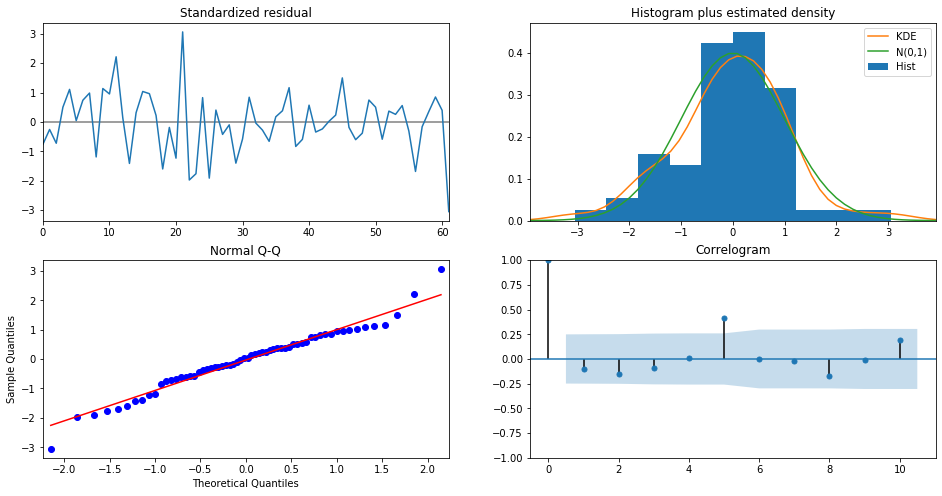

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -449.587
Date:                            Wed, 16 Jun 2021   AIC                            903.174
Time:                                    18:53:46   BIC                            907.428
Sample:                                         0   HQIC                           904.845
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4503      0.101      4.460      0.000       0.252       0.648
sigma2      1.036e+05   1.42e+04      7.299      0.000    7.58e+04    1.31e+05
===================================================================================
Ljung-Box (Q):                       53.13   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.08   Prob(JB):                         0.29
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

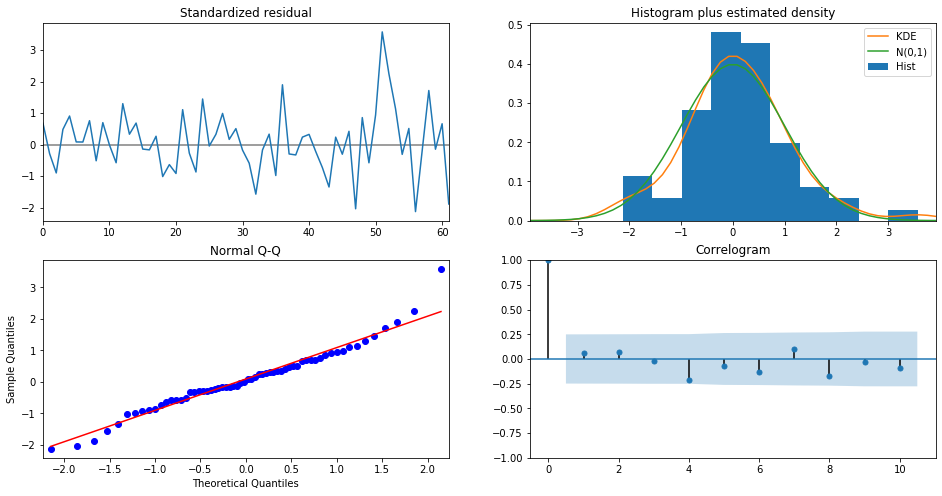

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -530.559
Date:                Wed, 16 Jun 2021   AIC                           1063.119
Time:                        18:53:47   BIC                           1065.246
Sample:                             0   HQIC                          1063.954
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.585e+06    2.1e+05      7.558      0.000    1.17e+06       2e+06
===================================================================================
Ljung-Box (Q):                       50.27   Jarque-Bera (JB):                 8.43
Prob(Q):                              0.13   Prob(JB):                         0.01
Heteroskedasticity (H):               4.56   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

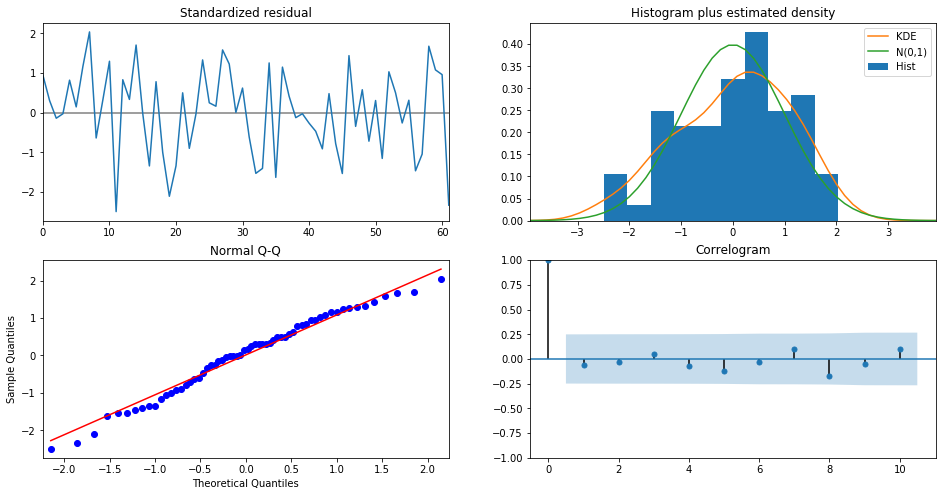

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -502.138
Date:                             Wed, 16 Jun 2021   AIC                           1010.275
Time:                                     18:53:48   BIC                           1016.657
Sample:                                          0   HQIC                          1012.781
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.097     -1.834      0.067      -0.366       0.012
ar.S.L12       0.4572      0.073      6.284      0.000       0.315       0.600
sigma2       5.28e+05   1.15e+05      4.610      0.000    3.04e+05    7.52e+05
===================================================================================
Ljung-Box (Q):                       22.86   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.99   Prob(JB):                         0.34
Heteroskedasticity (H):               0.82   Skew:                            -0.35
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

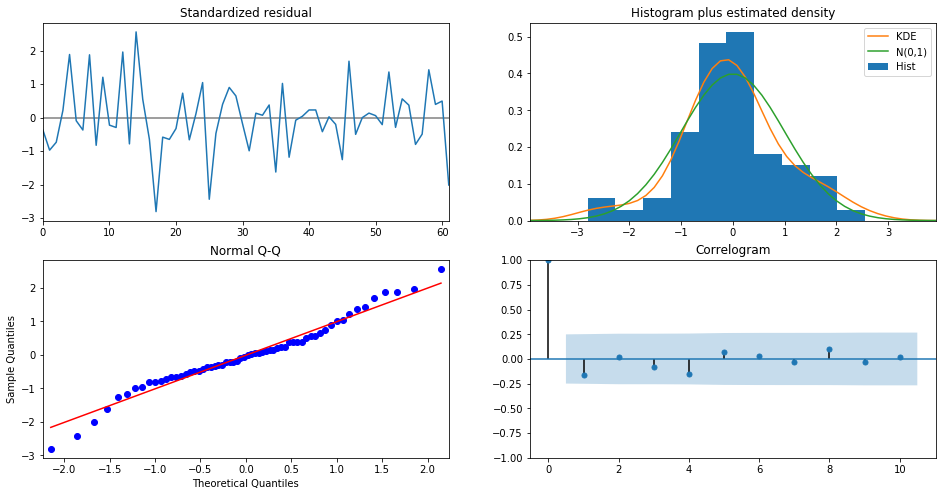

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -553.969
Date:                Wed, 16 Jun 2021   AIC                           1109.939
Time:                        18:53:49   BIC                           1112.066
Sample:                             0   HQIC                          1110.774
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.366e+06   5.16e+05      6.519      0.000    2.35e+06    4.38e+06
===================================================================================
Ljung-Box (Q):                       38.55   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.54   Prob(JB):                         0.50
Heteroskedasticity (H):               0.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

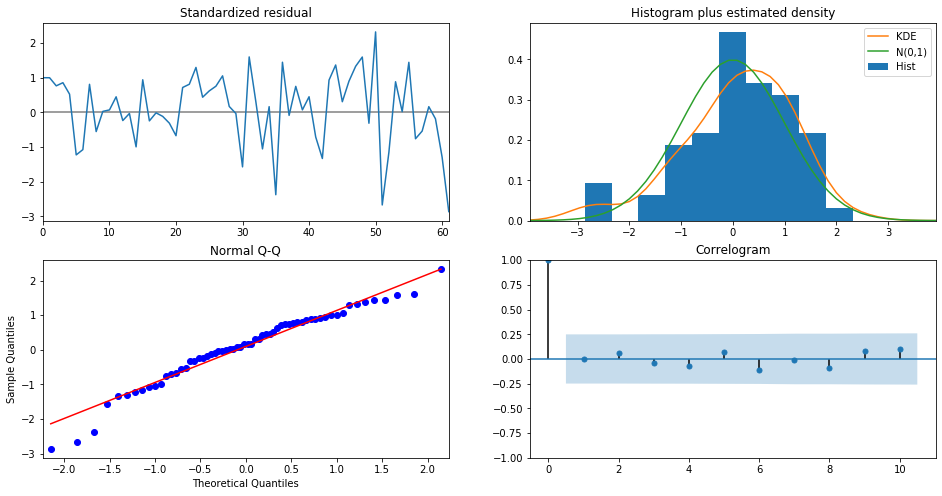

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -411.987
Date:                            Wed, 16 Jun 2021   AIC                            829.975
Time:                                    18:53:50   BIC                            836.356
Sample:                                         0   HQIC                           832.480
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.097     -2.542      0.011      -0.436      -0.056
ar.S.L12       0.3784      0.126      2.997      0.003       0.131       0.626
sigma2      3.064e+04   4852.945      6.314      0.000    2.11e+04    4.02e+04
===================================================================================
Ljung-Box (Q):                       35.31   Jarque-Bera (JB):                 5.49
Prob(Q):                              0.68   Prob(JB):                         0.06
Heteroskedasticity (H):               3.79   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

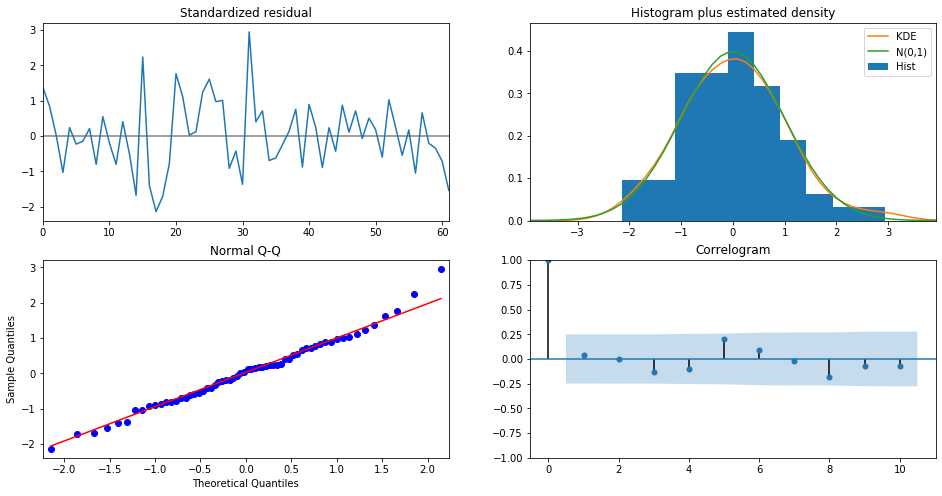

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -434.691
Date:                             Wed, 16 Jun 2021   AIC                            881.382
Time:                                     18:53:51   BIC                            894.145
Sample:                                          0   HQIC                           886.393
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3197      0.165     -8.018      0.000      -1.642      -0.997
ar.L2         -0.5661      0.111     -5.101      0.000      -0.784      -0.349
ma.L1          0.8918      0.140      6.364      0.000       0.617       1.166
ar.S.L12       0.1837      0.172      1.071      0.284      -0.153       0.520
ar.S.L24       0.2227      0.250      0.890      0.373      -0.267       0.713
sigma2      7.281e+04   1.49e+04      4.873      0.000    4.35e+04    1.02e+05
===================================================================================
Ljung-Box (Q):                       34.26   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.73   Prob(JB):                         0.49
Heteroskedasticity (H):               0.34   Skew:                             0.33
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

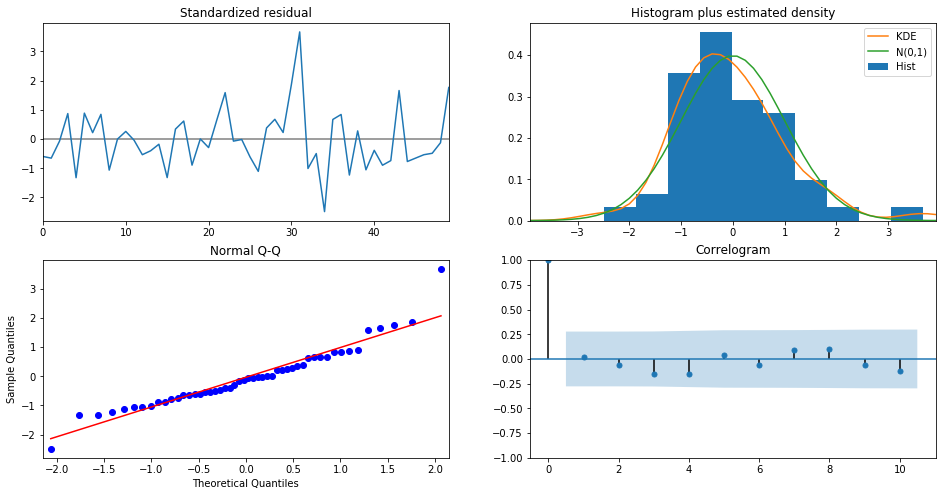

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -281.499
Date:                            Wed, 16 Jun 2021   AIC                            566.999
Time:                                    18:53:52   BIC                            570.823
Sample:                                         0   HQIC                           568.455
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3158      0.122     -2.595      0.009      -0.554      -0.077
sigma2      4258.8318    593.645      7.174      0.000    3095.310    5422.354
===================================================================================
Ljung-Box (Q):                       24.51   Jarque-Bera (JB):                17.03
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             0.92
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

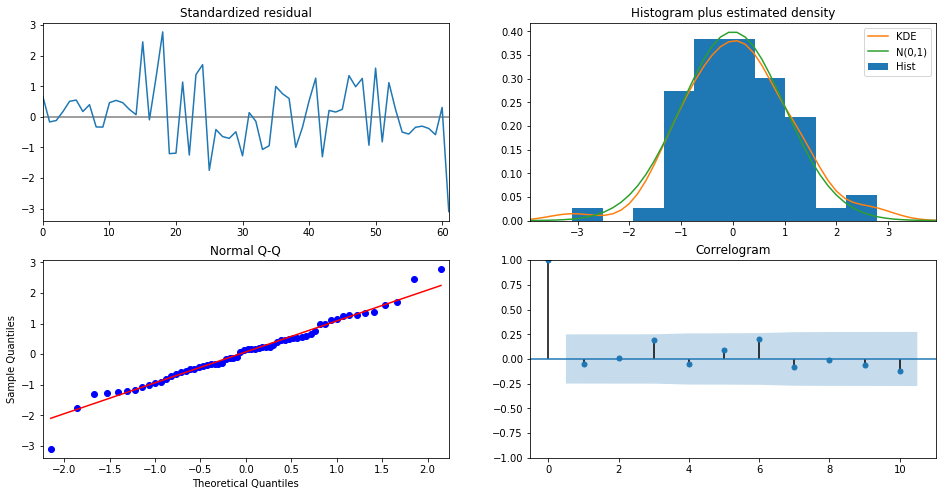

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -479.358
Date:                             Wed, 16 Jun 2021   AIC                            964.717
Time:                                     18:53:53   BIC                            971.098
Sample:                                          0   HQIC                           967.222
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2705      0.117     -2.306      0.021      -0.500      -0.041
ar.S.L12       0.3422      0.142      2.418      0.016       0.065       0.620
sigma2      2.886e+05   4.51e+04      6.399      0.000       2e+05    3.77e+05
===================================================================================
Ljung-Box (Q):                       35.34   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.68   Prob(JB):                         0.40
Heteroskedasticity (H):               1.18   Skew:                            -0.02
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

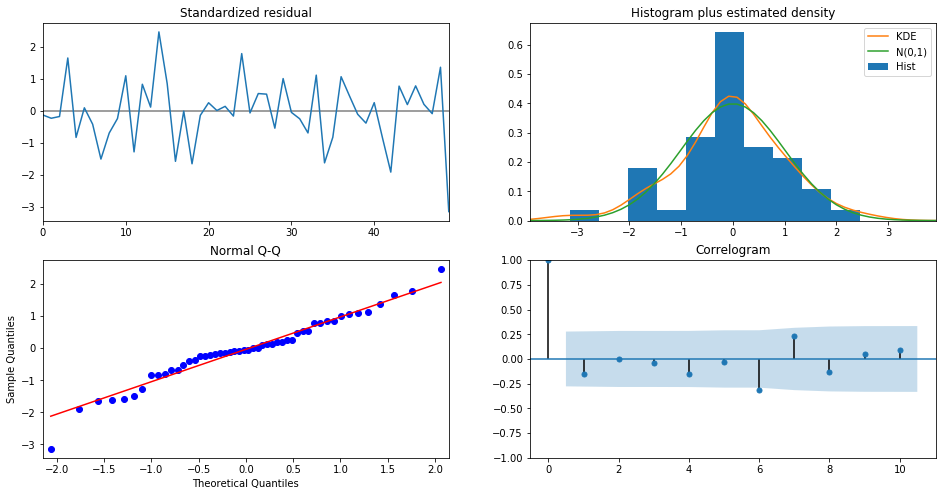

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -290.063
Date:                              Wed, 16 Jun 2021   AIC                            584.127
Time:                                      18:53:54   BIC                            587.951
Sample:                                           0   HQIC                           585.583
                                               - 63                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9753      3.313     -0.294      0.768      -7.469       5.518
sigma2      4324.2276   1.37e+04      0.315      0.753   -2.26e+04    3.12e+04
===================================================================================
Ljung-Box (Q):                       61.41   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.02   Prob(JB):                         0.28
Heteroskedasticity (H):               1.22   Skew:                            -0.34
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
for i in range(len(sales_s.columns)):
    models[i].plot_diagnostics(figsize=(16,8))
    plt.show()
    display(models[i].summary())

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

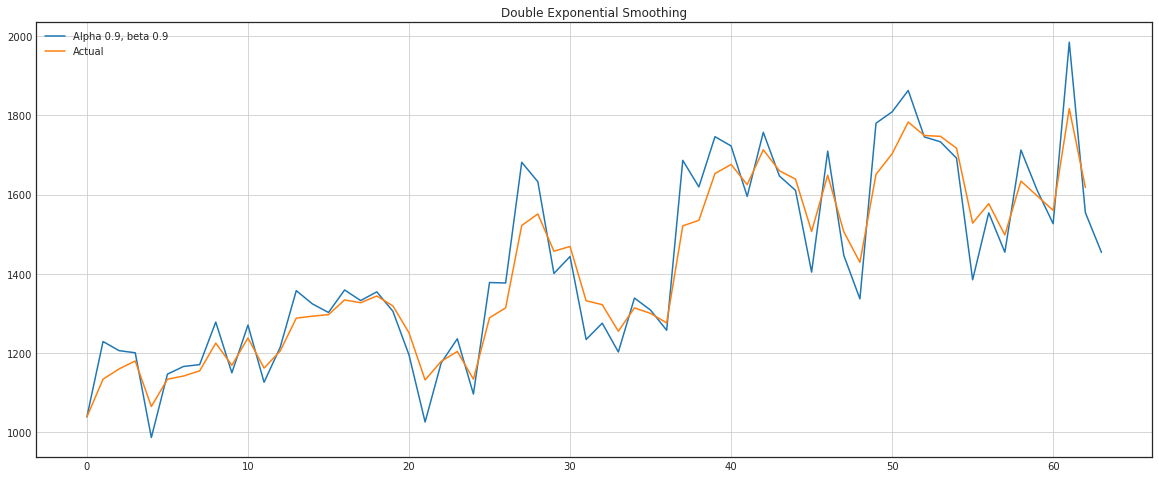

In [14]:
plotDoubleExponentialSmoothing(sales_s.P_64, alphas=[0.9], betas=[0.9])